In [1]:
import torch
import wandb
import torch.optim as optim
from utils.wandb import wandb_init
from train_rq_vae import train
from omegaconf import OmegaConf
from data.loader import load_mnist
from modules.rq_vae import RQ_VAE
from utils.model_id_generation import generate_model_id

In [2]:
cfg = OmegaConf.load('config/config_mnist.yaml')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb_init(cfg)

data = load_mnist(
    normalize_data=cfg.data.normalize_data,
    train=True)

model = RQ_VAE(
        input_dim = data.shape[1],
        latent_dim = cfg.model.latent_dimension,
        hidden_dims = cfg.model.hidden_dimensions,
        codebook_size = cfg.model.codebook_clusters,
        codebook_kmeans_init = True,
        codebook_sim_vq = True,
        n_quantization_layers = cfg.model.num_codebook_layers,
        commitment_weight = cfg.model.commitment_weight,
)
model.to(device)

wandb.watch(model)

optimizer = optim.AdamW(model.parameters(), lr=cfg.train.learning_rate, weight_decay=cfg.train.weight_decay)

wandb: Currently logged in as: hangoebl-j (justin-hangoebl-master-thesis) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
losses = train(model, data, optimizer, cfg.train.num_epochs, device, cfg)

if cfg.general.save_model:
    model_id = generate_model_id(cfg)
    torch.save(model.state_dict(), f"models/{model_id}.pth")
    
wandb.finish()

Training Loop: 100%|██████████| 5/5 [00:40<00:00,  8.13s/it, Epoch=4, Loss=7.65e+4, Reconstruction Loss=7.65e+4, RQ-VAE Loss=15.2, Prob Unique IDs=0.266]     


Epoch,▁▃▅▆█
Loss,█▂▂▂▁
Prob Unique IDs,▁▁▂▄█
RQ-VAE Loss,█▁▁▁▁
Reconstruction Loss,█▅▄▃▁
Epoch,4
Loss,76549.03913
Prob Unique IDs,0.26629
RQ-VAE Loss,15.18617
Reconstruction Loss,76533.85249


In [4]:
data_test, labels = load_mnist(
    normalize_data=cfg.data.normalize_data,
    train=False)

sem_ids = []
model.eval()

with torch.no_grad():
    test_loss = 0
    for i in range(len(data_test)):
        x = data_test[i].unsqueeze(0).to(device)
        id = model.get_semantic_id_single(x[0])
        sem_ids.append(id.cpu().numpy())

In [5]:
import numpy as np
sem_ids =np.array(sem_ids, dtype=np.float32)
labels = [int(label.cpu()) for label in labels]

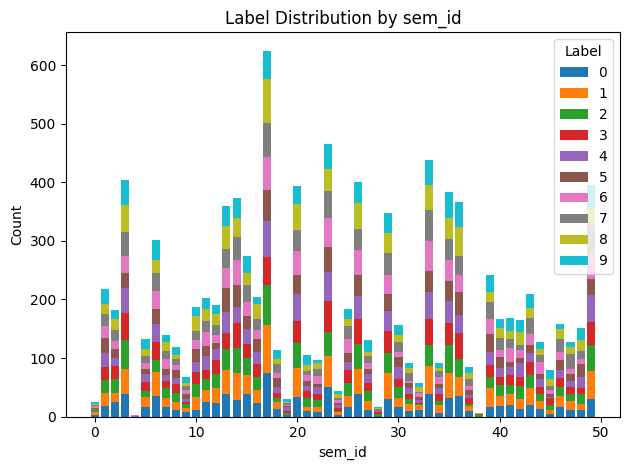

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Flatten sem_ids if it's shaped (n, 1)
sem_ids = sem_ids.flatten()

# Get all unique sem_ids and labels
unique_sem_ids = np.unique(sem_ids)
unique_labels = sorted(set(labels))
label_index = {label: i for i, label in enumerate(unique_labels)}

# Count occurrences of each label per sem_id
stack_data = defaultdict(lambda: [0] * len(unique_labels))

for sem_id, label in zip(sem_ids, labels):
    stack_data[sem_id][label_index[label]] += 1

# Prepare data for plotting
x_vals = sorted(stack_data.keys())
bar_data = np.array([stack_data[x] for x in x_vals])

# Plot
bottom = np.zeros(len(x_vals))
for i, label in enumerate(unique_labels):
    plt.bar(x_vals, bar_data[:, i], bottom=bottom, label=f'{label}')
    bottom += bar_data[:, i]

plt.xlabel('sem_id')
plt.ylabel('Count')
plt.title('Label Distribution by sem_id')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

In [7]:


import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))

# Add small random noise (jitter) for better visualization
np.random.seed(0)  # for reproducibility
jitter_strength = 0.5
sem_ids_rand = sem_ids + np.random.uniform(-jitter_strength, jitter_strength, sem_ids.shape)
print(sem_ids_rand)
# Plot
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    sem_ids_rand[:, 0], sem_ids_rand[:, 1],
    c=labels,
    cmap='tab10',
    s=10,
    alpha=0.6,
    edgecolors='none'
)

# Colorbar for labels
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('Label')
cbar.set_ticks(range(10))

plt.xlim(-0.5, 9.5)
plt.ylim(-0.5, 9.5)
plt.xticks(range(11))
plt.yticks(range(11))
plt.grid(True, linestyle='--', alpha=0.3)
plt.title("10x10 Scatter Plot with Label-Based Coloring and Jitter")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

[ 1.0488135   3.21518937 17.10276338 ... 41.94645576  4.86012661
 31.12588665]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>